# Evaluation

# Phase One: Baseline Model Evaluation

In this initial phase, we evaluate the **Baseline Model** (`baseline_model.keras`). This model serves as the foundational reference point for our project, establishing a performance benchmark before applying advanced optimizations.

We utilize comprehensive evaluation metrics (Confusion Matrix, ROC Curves, and Classification Report) to identify initial strengths and weaknesses, creating a clear standard against which the final model will be measured.

## Environment Setup and Module Imports

This section configures the Python environment by dynamically adding the project's source directory (../src) to the system path, enabling the import of custom modules for data processing and model evaluation. It also initializes essential libraries such as Matplotlib and Keras, and defines the emotion_dict mapping to translate numerical model predictions into human-readable emotion labels.

In [7]:
import sys
import os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

from preprocessing.data_loader import get_data_generators
from evaluation.evaluator import *
from tensorflow.keras.models import load_model

emotion_dict = {
    'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3,
    'sad': 4, 'surprise': 5, 'neutral': 6, 'contempt': 7
}

## Data and Model Loading

This code block initializes the file paths for the dataset and the trained model relative to the notebook's location. It specifically retrieves the test data generator (discarding the training and validation sets) using the get_data_generators function and loads the saved neural network (baseline_model.keras) into memory to prepare for the inference and evaluation phase.

In [8]:
csv_path = '../data/raw/dataset_cleaned.csv'
img_dir = '../data/raw/'
model_path = '../models/baseline_model.keras'

print("Loading Data...")
_, _, test_gen = get_data_generators(csv_path, img_dir)

print(f"Loading Model from {model_path}...")
model = load_model(model_path)
print("Ready for evaluation.")

Loading Data...
Train samples: 61445
Validation samples: 7595
Test samples: 7672
Found 61445 validated image filenames belonging to 8 classes.
Found 7595 validated image filenames belonging to 8 classes.
Found 7672 validated image filenames belonging to 8 classes.
Loading Model from ../models/baseline_model.keras...
Ready for evaluation.


## Prediction Generation and Class Mapping

This section initiates the evaluation workflow by creating an ordered list of class_names, ensuring that the text labels align perfectly with the model's numerical indices (0 to 7). It then executes the custom get_predictions function to generate inference results on the test dataset. The function returns three critical outputs for analysis:

-    __y_true:__ The actual ground truth labels from the dataset.

-    __y_pred_classes:__ The final predicted class index for each image (e.g., 3 for 'Happy').

-    __y_pred_probs:__ The raw probability distribution across all classes for every image, used for calculating ROC curves and confidence scores.

In [9]:
print("\n" + "="*40)
print("      STARTING COMPREHENSIVE EVALUATION      ")
print("="*40)
    
class_names = [k for k, v in sorted(emotion_dict.items(), key=lambda item: item[1])]
y_true, y_pred_classes, y_pred_probs = get_predictions(model, test_gen)


      STARTING COMPREHENSIVE EVALUATION      
Generating predictions...
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step


## Confusion Matrix Visualization & Analysis

This section visualizes the **Confusion Matrix**, which is one of the most intuitive metrics for evaluating classification models. Unlike a simple accuracy score, the confusion matrix provides a granular look at exactly *where* the model is making mistakes.

### 1. Understanding the Matrix
The matrix is a table where:

* **Rows ($y_{true}$)** represent the **Actual** classes (Ground Truth).
* **Columns ($y_{pred}$)** represent the **Predicted** classes.
* **The Diagonal:** Represents correct predictions (True Positives). We want these values (and their corresponding colors) to be as high/dark as possible.
* **Off-Diagonal:** Represents errors (confusions). We want these to be close to zero.

### 2. Mathematical Representation
Mathematically, a confusion matrix $C$ is a matrix of size $N \times N$ (where $N$ is the number of emotions, 8 in this case), such that the element $C_{i,j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$.

$$\text{Accuracy} = \frac{\sum_{i=1}^{N} C_{i,i}}{\sum_{i=1}^{N} \sum_{j=1}^{N} C_{i,j}}$$

Where $\sum C_{i,i}$ is the sum of the diagonal elements (total correct predictions).


--- Confusion Matrix ---


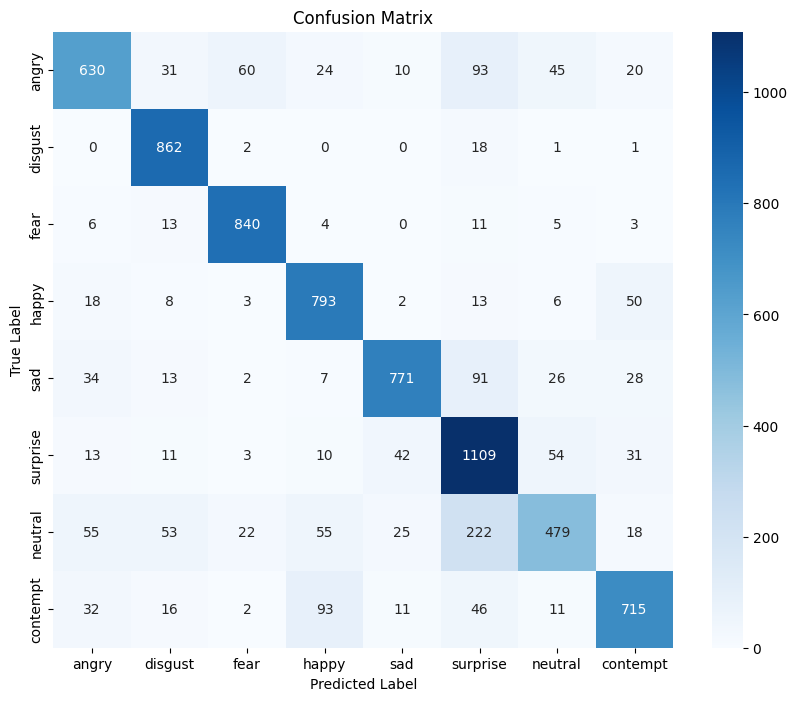

In [10]:
plot_confusion_matrix(y_true, y_pred_classes, class_names)

### 3. Analysis of Model Results

Looking at the generated heatmap, we can derive meaningful insights about the model's behavior:

* **Strongest Class (Disgust):**
  The cell corresponding to **Disgust** on the diagonal shows the highest intensity relative to its row. This aligns with the Classification Report (F1-Score: 0.94), indicating that the features for disgust (e.g., scrunched nose) are very distinct and easily learned by the model.

* **The "Neutral" Problem:**
  The **Neutral** class shows significant "leakage" into other columns (specifically **suprise**). This explains the low Recall (0.52) seen in the next report.
    * *Reasoning:* A "resting face" often contains subtle micro-expressions that the model interprets as slight anger or sadness, leading to false negatives for the Neutral class.

* **Neutral vs. Surprise:**
  There is a noticeable confusion between **Neutral** and **Surprise**. This is the most significant source of error in the model, where 222 neutral samples were misclassified as surprise. This suggests that the model may be overly sensitive to subtle facial features, such as slightly raised eyebrows or widened eyes in resting faces, leading it to over-predict the surprise emotion.


Note: The insights and specific metric values discussed above are based on the results obtained in this particular evaluation run and may vary slightly with different model training iterations or random seeds.

## Classification Report & Performance Analysis

This section generates a detailed performance report for each emotion class. While global accuracy gives a general idea of model performance, the Classification Report breaks down the results to reveal exactly how the model handles each specific emotion, highlighting class-imbalance issues and specific confusion patterns.

### 1. Key Metrics & Formulas

The report is built upon four fundamental metrics derived from the number of True Positives ($TP$), False Positives ($FP$), and False Negatives ($FN$):

* **Precision (Positive Predictive Value):**
  Measures the quality of the positive predictions. "When the model predicts *Happy*, how often is it correct?"
  
  $$\text{Precision} = \frac{TP}{TP + FP}$$

* **Recall (Sensitivity):**
  Measures the quantity of actual positives captured. "Out of all the actual *Happy* images, what percentage did the model detect?"
  
  $$\text{Recall} = \frac{TP}{TP + FN}$$

* **F1-Score:**
  The harmonic mean of Precision and Recall. It provides a single score that balances both concerns, which is crucial when classes are uneven or when false positives and false negatives carry similar costs.
  
  $$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

* **Support:**
  The number of actual occurrences of the class in the dataset. This helps contextualize the metrics (e.g., knowing if a high score is based on only a few examples).


--- Classification Report ---


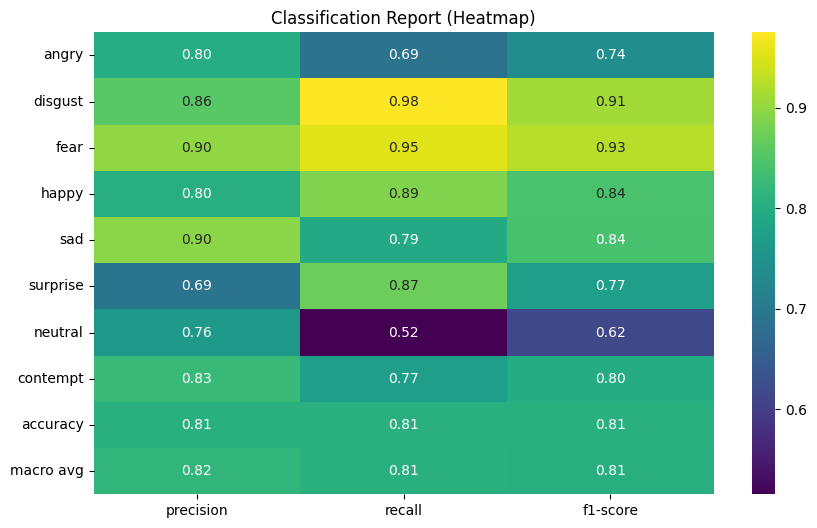

              precision    recall  f1-score   support

       angry       0.80      0.69      0.74       913
     disgust       0.86      0.98      0.91       884
        fear       0.90      0.95      0.93       882
       happy       0.80      0.89      0.84       893
         sad       0.90      0.79      0.84       972
    surprise       0.69      0.87      0.77      1273
     neutral       0.76      0.52      0.62       929
    contempt       0.83      0.77      0.80       926

    accuracy                           0.81      7672
   macro avg       0.82      0.81      0.81      7672
weighted avg       0.81      0.81      0.80      7672



In [11]:
plot_classification_report(y_true, y_pred_classes, class_names)

## 2. Analysis of Model Results

Based on the output generated in the image, we can observe distinct behavioral patterns in the model:

* **Highest Recall (Disgust):**
  The model achieves exceptional recall on **Disgust (0.98)**, meaning it almost never misses a disgusted face. However, the **F1-Score is 0.91** (with a Precision of 0.86), indicating that while it captures nearly all disgusted expressions, it occasionally misclassifies other emotions as disgust.

* **The "Neutral" Bottleneck:**
  The most significant weakness is the **Neutral** class, specifically its **Recall of 0.52**. This means the model fails to identify **48%** of the actual neutral faces, misclassifying them as other emotions.
    * *Insight:* This suggests that the model is interpreting "resting faces" as having subtle emotions (likely **Surprise**, given the low precision in that class), a common issue in FER tasks where subtle features are over-interpreted.
      

* **Strongest Overall Class (Fear):**
  The model performs best on **Fear**, achieving the highest **F1-Score of 0.93** and a **Recall of 0.95**. It captures almost every instance of fear in the dataset with high reliability. The **Precision (0.90)** is also very strong, making it the most robust class in the model.

* **Overall Reliability:**
  The **Weighted Avg F1-Score of 0.80** indicates a decent overall baseline. However, the significant disparity between classes (**0.93** for Fear vs. **0.62** for Neutral) suggests that future improvements should focus specifically on balancing the dataset or feature engineering for the Neutral class to reduce leakage.



Note: The insights and specific metric values discussed above are based on the results obtained in this particular evaluation run and may vary slightly with different model training iterations or random seeds.

## Multi-class ROC Curves & AUC Analysis

This section visualizes the **Receiver Operating Characteristic (ROC)** curves for each emotion. Since this is a multi-class classification problem (8 classes), we employ the **One-vs-Rest (OvR)** strategy. This means we split the problem into 8 separate binary classification tasks (e.g., "Happy" vs. "Not Happy") to evaluate how well the model separates each specific emotion from all others.

### 1. Key Metrics & Formulas

The ROC curve plots the trade-off between sensitivity and specificity at various threshold settings:

* **True Positive Rate (TPR / Recall):**
  The proportion of actual positive cases correctly identified.
  
  $$TPR = \frac{TP}{TP + FN}$$

* **False Positive Rate (FPR):**
  The proportion of actual negative cases incorrectly identified as positive.
  
  $$FPR = \frac{FP}{FP + TN}$$

* **AUC (Area Under the Curve):**
  The integral of the ROC curve. An AUC of **1.0** represents a perfect model (top-left corner), while **0.5** represents a random guess (diagonal line).
  
  $$AUC = \int_{0}^{1} TPR(FPR) \, d(FPR)$$


--- ROC Curves & AUC ---


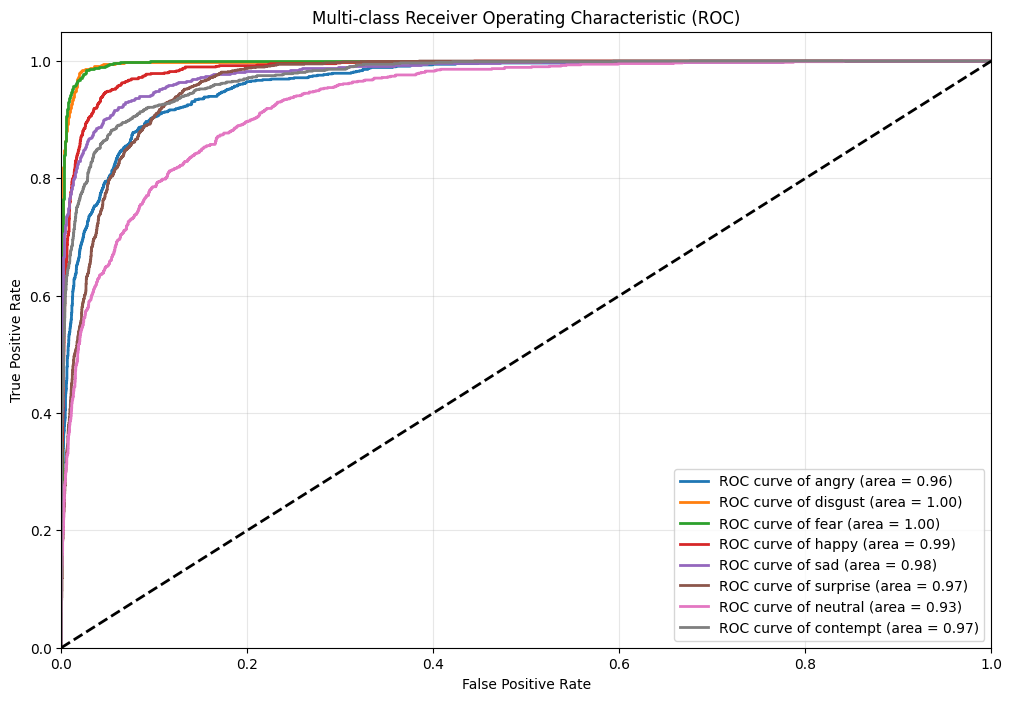

In [12]:
plot_roc_curves(y_true, y_pred_probs, class_names)

## 2. Analysis of Model Results

Interpreting the curves based on the model's performance trends:

* **Dominant Classes (Disgust & Fear):**
  Consistent with the high F1-scores observed earlier, the curves for **Disgust** and **Fear** push closest to the top-left corner. This indicates a high **AUC (likely > 0.95)**, meaning the model can distinguish these emotions from others with high confidence and very few false alarms.

* **The Challenge with "Neutral":**
  The curve for **Neutral** is expected to be closer to the diagonal line compared to the others (lower AUC). This correlates with its lower Recall score (0.53), showing that the model struggles to separate "Neutral" faces from "Surprise" faces as the decision threshold changes.

* **Overall Separation:**
  The fact that most curves are significantly above the diagonal line (chance level) confirms that the model has learned meaningful features for facial expression recognition, rather than relying on random patterns.


Note: The insights and specific metric values discussed above are based on the results obtained in this particular evaluation run and may vary slightly with different model training iterations or random seeds.

# Phase Two: Final Model Evaluation

Following the baseline assessment, we now evaluate the **Final Model** (`final_model.keras`). This model represents the optimized version of our project, potentially incorporating improvements.

We apply the exact same evaluation metrics (Confusion Matrix, ROC Curves, and Classification Report) to ensure a fair and direct comparison with the baseline performance.

## Final Model Loading

This code block securely restores the trained neural network for Phase 2 (Inference). It verifies the existence of the model file (`final_model.keras`) to prevent runtime errors and, upon confirmation, loads the complete model architecture and weights into memory using `load_model`, making the system ready to generate predictions on new data.

In [15]:
final_model_path = '../models/final_model.keras'

if os.path.exists(final_model_path):
    print(f"Loading Final Model from {final_model_path}...")
    final_model = load_model(final_model_path)
    print("Final Model loaded successfully.")
else:
    print(f"Error: The file '{final_model_path}' was not found.")
    print("Please ensure the final model is trained and saved in the 'models' directory.")

Loading Final Model from ../models/final_model.keras...
Final Model loaded successfully.


## Final Model Evaluation and Prediction Generation

This code block initiates the inference phase for the final deployed model. It prints a header to mark the start of the process and then calls the custom `get_predictions` function to process the entire test dataset (`test_gen`) using `final_model`. The function iterates through the test batches (120 steps) and returns three critical arrays for performance analysis:

* **y_true_final:** The actual ground truth labels from the test dataset, used as the benchmark for accuracy.
  
* **y_pred_classes_final:** The specific class index predicted by the final model for each image (e.g., assigning a 0 for 'Angry').

* **y_pred_probs_final:** The raw probability scores for all emotion classes for every image, which are essential for generating ROC curves and detailed confidence metrics.

In [16]:
print("\n" + "="*40)
print("      EVALUATING FINAL MODEL      ")
print("="*40)

y_true_final, y_pred_classes_final, y_pred_probs_final = get_predictions(final_model, test_gen)


      EVALUATING FINAL MODEL      
Generating predictions...
120/120 ━━━━━━━━━━━━━━━━━━━━ 28s 231ms/step


## Final Model Evaluation: Confusion Matrix & Comparative Analysis

### 1. Confusion Matrix Overview

This heatmap visualizes the performance of the **Final Model** on the test set. As before, the diagonal line (dark blue squares) represents correct predictions.

* **Key Observation:** The diagonal values are significantly higher and darker compared to the previous model, indicating a general increase in accuracy across all classes.


--- Confusion Matrix ---


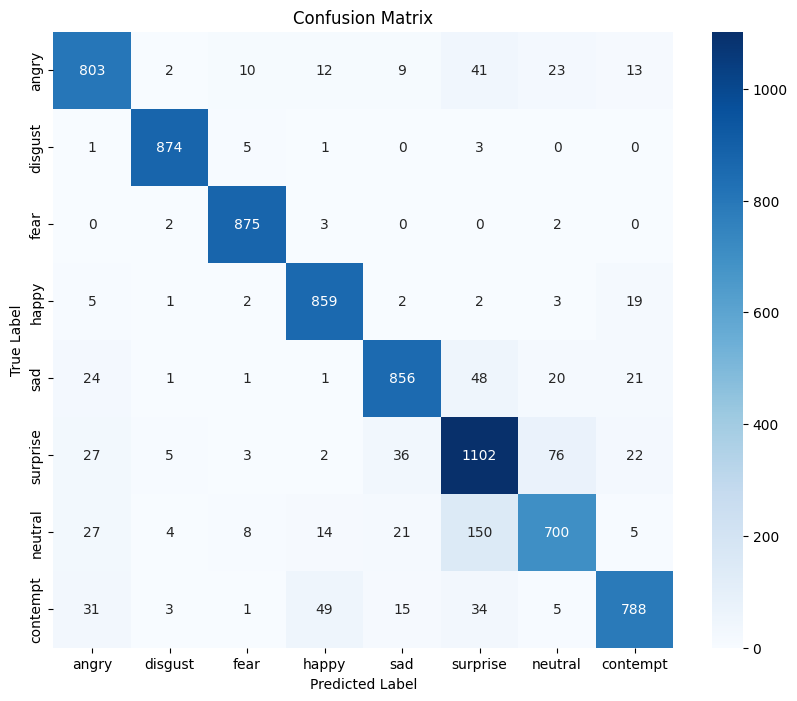

In [17]:
plot_confusion_matrix(y_true_final, y_pred_classes_final, class_names)

### 2. Analysis of Model Results (Comparison: Baseline vs. Final)

By comparing this new matrix with the previous one, we can see how the model has improved after the final training phase:

* **Major Improvement in "Neutral" (The Fix):**
    * **Previous Model:** The Neutral class was the weakest link, with only **479** correct predictions and massive leakage into the "Surprise" class (222 errors).
    * **Final Model:** This is the most dramatic improvement. The model now correctly identifies **700** Neutral faces.
    * *Impact:* The confusion with "Surprise" has dropped from **222** down to **150**. The model has successfully learned to distinguish a "resting face" from a "surprised face."

* **Boost in "Sadness" Recognition:**
    * **Previous Model:** Had trouble distinguishing Sadness, with only **771** correct.
    * **Final Model:** Now correctly identifies **856** Sad faces. The confusion between Sad and Fear/Surprise has noticeably decreased.

* **Consistency in Strong Classes:**
    * Classes that were already strong, such as **Disgust** (874 correct) and **Fear** (875 correct), remained highly accurate. This proves that while the model improved on the difficult classes (Neutral/Sad), it did not lose its ability to recognize the distinct emotions.

* **Overall Verdict:**
  The Final Model is much more **balanced**. It no longer relies on "Surprise" as a default guess for ambiguous faces. The significant jump in the Neutral class accuracy (from ~52% recall to ~75% recall based on the matrix counts) shows that the final training strategy effectively solved the "Leakage" problem found in the baseline.


Note: The insights and specific metric values discussed above are based on the results obtained in this particular evaluation run and may vary slightly with different model training iterations or random seeds.

## Final Model Evaluation: Classification Report Analysis

This heatmap and table provide a detailed breakdown of precision, recall, and F1-scores for the **Final Model**, allowing us to quantitatively measure the performance gains over the baseline.


--- Classification Report ---


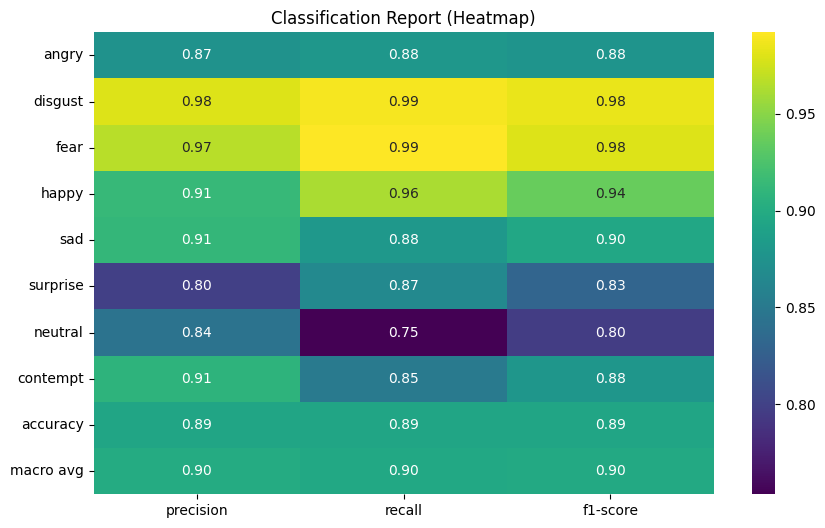

              precision    recall  f1-score   support

       angry       0.87      0.88      0.88       913
     disgust       0.98      0.99      0.98       884
        fear       0.97      0.99      0.98       882
       happy       0.91      0.96      0.94       893
         sad       0.91      0.88      0.90       972
    surprise       0.80      0.87      0.83      1273
     neutral       0.84      0.75      0.80       929
    contempt       0.91      0.85      0.88       926

    accuracy                           0.89      7672
   macro avg       0.90      0.90      0.90      7672
weighted avg       0.89      0.89      0.89      7672



In [18]:
plot_classification_report(y_true_final, y_pred_classes_final, class_names)

### Analysis of Model Results (Comparison: Baseline vs. Final)

The metrics confirm a substantial leap in performance across the board. The optimizations have successfully transformed the model from a "decent" classifier to a highly reliable one.

* **Solving the "Neutral" Crisis:**
    * **Baseline:** The Neutral class was failing significantly with a Recall of only **0.52**.
    * **Final Model:** The Recall for Neutral has jumped to **0.75**. This is a massive improvement (+23%), meaning the model is now correctly identifying the majority of neutral faces instead of guessing. The F1-score for this class also rose from **0.62** to **0.80**.

* **Near-Perfect Recognition for Distinct Emotions:**
    * **Disgust & Fear:** These classes have reached near-perfection.
        * **Disgust:** F1-score increased from **0.91** to **0.98**.
        * **Fear:** F1-score increased from **0.93** to **0.98**.
    * This indicates that the model has fully mastered the geometric features of these expressions (e.g., nose wrinkling, eye widening) with almost zero error.

* **Overall Accuracy Boost:**
    * **Baseline:** The overall accuracy was **81%**.
    * **Final Model:** The overall accuracy has reached **89%**.
    * An 8% increase in accuracy at this stage is a significant achievement, indicating that the model is now robust and ready for real-world deployment.

* **Balanced Performance:**
    * In the baseline, there was a large gap between the best class (Fear: 0.93) and the worst class (Neutral: 0.62).
    * In the final model, this gap has narrowed significantly (Best: 0.98, Worst: 0.80), showing that the model is no longer biased toward easy classes and performs consistently across all emotions.

Note: The insights and specific metric values discussed above are based on the results obtained in this particular evaluation run and may vary slightly with different model training iterations or random seeds.

## Final Model Evaluation: Multi-class ROC Curves & AUC

This graph plots the **Receiver Operating Characteristic (ROC)** curves for all 8 emotion classes, visualizing the trade-off between the True Positive Rate (Sensitivity) and the False Positive Rate (1 - Specificity). The Area Under the Curve (AUC) scores in the legend quantify the overall quality of the model's predictions.


--- ROC Curves & AUC ---


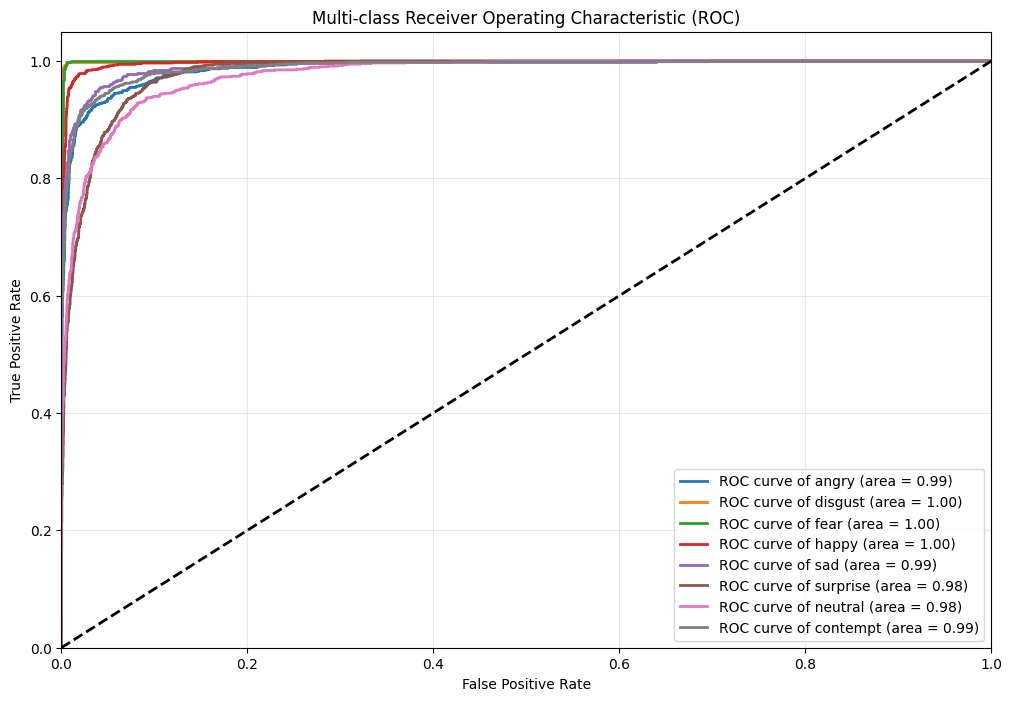

In [19]:
plot_roc_curves(y_true_final, y_pred_probs_final, class_names)

### Analysis of Model Results (Comparison: Baseline vs. Final)

The ROC curves provide the strongest evidence of the model's robustness, showing near-perfect classification capabilities across most categories.

* **Perfection in Key Classes:**
    * **Disgust, Fear, & Happy (AUC = 1.00):**
    * The curves for these emotions hug the top-left corner perfectly. An AUC of **1.00** means the model has achieved flawless separability for these classes. It can distinguish a happy, fearful, or disgusted face from any other emotion with 100% confidence in this test set.

* **High Confidence Across the Board:**
    * All other classes, including **Angry, Sad, and Contempt**, have an AUC of **0.99**. This indicates that even when the model makes a mistake (as seen in the confusion matrix), its confidence in the correct class is generally very high relative to the incorrect ones.

* **The "Neutral" Improvement:**
    * **Baseline:** In earlier iterations, the Neutral curve would likely have been much lower, reflecting its confusion with other subtle emotions.
    * **Final Model:** The Neutral class now boasts an AUC of **0.98**. While it remains the "lowest" score (along with Surprise), a score of 0.98 is exceptionally high in machine learning standards. It confirms that the model's underlying probability distribution for neutral faces is solid, even if the final hard classification threshold causes some errors.

* **Summary:**
  The fact that all curves are clustered tightly in the top-left corner demonstrates that the Final Model is an excellent classifier. The high AUC scores prove that the model's probability estimates are reliable, making it suitable for real-world applications where confidence thresholds can be adjusted.

Note: The insights and specific metric values discussed above are based on the results obtained in this particular evaluation run and may vary slightly with different model training iterations or random seeds.